In [1]:
!git clone https://github.com/NVlabs/stylegan3
!pip install einops ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 26.55 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 560.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 6.0 MB/s eta 0:00:00


In [10]:
import sys
sys.path.append('./stylegan3')
import os
import pickle
import torch
from torchvision.transforms import Compose, Resize
import torchvision.transforms.functional as TF

device = torch.device('cuda:0') # на GPU
print('Using device:', device, file=sys.stderr)

Using device: cuda:0


In [3]:
!wget -c "https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl"

--2024-03-24 22:08:06--  https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 52.27.252.135, 52.34.183.109, 35.86.41.132, ...
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|52.27.252.135|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://files.ngc.nvidia.com/org/nvidia/team/research/models/stylegan3/versions/1/files/stylegan3-t-ffhqu-1024x1024.pkl?Expires=1711321686&Signature=asS7QIrh2yP9bXzbqmcBlORwax-A7kksST77YGJTrOmlwcyXvw~ENBRG~4QcxEWyyy7sADgGlOGT6EH3y4iQkYW4fmKRQbd8ES5yMeTRtsj4e9wyOFmqSGfpMcOiRQZr6XVr7Cg31GBBQx1ZhiFJtTs7UVwun5w7Dr4KKBuFs0efRiboWTtwGzi4Y01pepcnfqKGxgIIA11i2acyN5KXxRLD9jcKs4yGxg0bDSLfb5bZZXvPCfRdUFZnkgXqmsuYJI1slSzaNJNDfftcNutngdj0OtgUFAPYUxbgkjvp1oG7W-dj1lBBJou0JeJ4AJaosMTqrXg9wW8AVqujERTSmA__&Key-Pair-Id=KCX06E8E9L60W [following]
--2024-03-24 22:08:06--  https://files.ngc.nvidia.com/org/nvidia/team/research/mode

In [7]:
with open(os.path.basename("stylegan3-t-ffhqu-1024x1024.pkl"), 'rb') as fp:
  G = pickle.load(fp)['G_ema'].to(device)

In [5]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

D = InceptionV3(weights='imagenet', include_top=False, pooling='avg')# Загрузить любую из предобученных сетей распознавания изображений, которая может сопоставлять вектора изображениям, обозначим сеть С.


87910968/87910968 [==============================] - 1s 0us/step


In [ ]:

# zs = torch.randn([6, G.mapping.z_dim], device=device) # латентные вектора
# display(len(zs[0]))
# w_stds = G.mapping(zs, None).std(0) # отображаем их в стилевые W, считаем среднее (уже есть) и разброс.
# display(len(w_stds[0]))
# # Первый запуск может быть долгим!
# G.mapping.w_avg; # здесь среднее

512

Setting up PyTorch plugin "bias_act_plugin"... Done.


512

In [ ]:
# q = (G.mapping(torch.randn([1,G.mapping.z_dim], device=device), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
# image=G.synthesis(q * w_stds + G.mapping.w_avg)
# # Первый запуск может быть долгим!

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


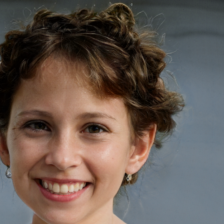

In [ ]:
# tf = Compose([
#   Resize(224),
#   lambda x: torch.clamp((x+1)/2,min=0,max=1),
#   ])
# display(TF.to_pil_image(tf(image)[0])) # отображаем

### **Эксперимент 1**

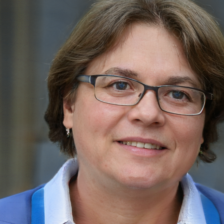

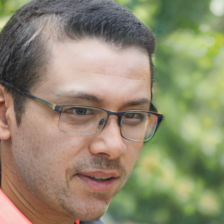

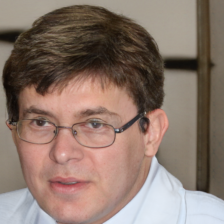

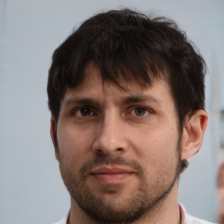

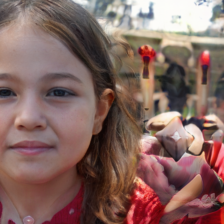

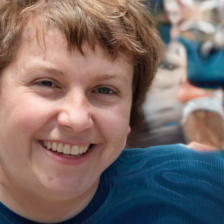

In [11]:
zs = torch.randn([6, G.mapping.z_dim], device=device)
w_stds = G.mapping(zs, None).std(0) # отображаем их в стилевые W, считаем среднее (уже есть) и разброс.


# Генерируем изображения для этих латентных векторов
generated_images = []
for latent_vector in zs:
    q = (G.mapping(latent_vector.unsqueeze(0), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    image = G.synthesis(q * w_stds + G.mapping.w_avg)
    generated_images.append(image)

# Отображаем сгенерированные изображения
tf = Compose([
    Resize(224),
    lambda x: torch.clamp((x + 1) / 2, min=0, max=1),
])
for i, image in enumerate(generated_images):
    display(TF.to_pil_image(tf(image)[0]))

In [12]:
import numpy as np
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
from tabulate import tabulate
from sklearn.metrics.pairwise import cosine_similarity



# Предобработка изображений
preprocessed_images = []
for image in generated_images:
    # Удаление лишнего измерения
    image = image.squeeze(0)
    # Преобразование изображения в формат, подходящий для входа в InceptionV3
    image = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))  # Преобразование тензора в изображение
    image = image.resize((299, 299))  # Размер изображения должен быть 299x299 для InceptionV3
    image = np.array(image)
    image = preprocess_input(image)  # Предобработка изображения для InceptionV3
    preprocessed_images.append(image)


# Преобразование списка предобработанных изображений в массив numpy
preprocessed_images = np.array(preprocessed_images)

# Передача изображений через InceptionV3 и получение векторов
image_vectors = D.predict(preprocessed_images)

# Вывод косинусной похожести векторов изображений
image_similarity = cosine_similarity(image_vectors)
latent_similarity = cosine_similarity(zs.cpu().numpy())


def display_similarity_table(similarity_matrix, title):
    headers = [""] + [f"Image {i+1}" for i in range(len(similarity_matrix))]
    rows = [[f"Image {i+1}"] + [round(similarity, 4) for similarity in row] for i, row in enumerate(similarity_matrix)]
    print(title)
    print(tabulate(rows, headers=headers, tablefmt="grid"))
    print()

# Вывод таблицы косинусной похожести векторов изображений
display_similarity_table(image_similarity, "Cosine Similarity between Image Vectors")

# Вывод таблицы косинусной похожести латентных векторов
display_similarity_table(latent_similarity, "Cosine Similarity between Latent Vectors")

1/1 [==============================] - 5s 5s/step
Cosine Similarity between Image Vectors
+---------+-----------+-----------+-----------+-----------+-----------+-----------+
|         |   Image 1 |   Image 2 |   Image 3 |   Image 4 |   Image 5 |   Image 6 |
+=========+===========+===========+===========+===========+===========+===========+
| Image 1 |    1      |    0.8288 |    0.834  |    0.7309 |    0.7736 |    0.7752 |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+
| Image 2 |    0.8288 |    1      |    0.7419 |    0.6733 |    0.7279 |    0.7527 |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+
| Image 3 |    0.834  |    0.7419 |    1      |    0.7895 |    0.7566 |    0.7353 |
+---------+-----------+-----------+-----------+-----------+-----------+-----------+
| Image 4 |    0.7309 |    0.6733 |    0.7895 |    1      |    0.7765 |    0.7393 |
+---------+-----------+-----------+-----------+-----------+-----------

### Эксперимент 2

19/19 [==============================] - 11s 336ms/step


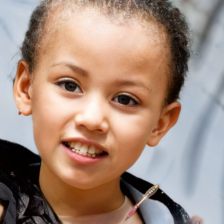

In [13]:
zs = torch.randn([600, G.mapping.z_dim], device=device)

# Генерируем изображения для этих латентных векторов
generated_images = []
for latent_vector in zs:
    q = (G.mapping(latent_vector.unsqueeze(0), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    image = G.synthesis(q * w_stds + G.mapping.w_avg)
    generated_images.append(image)

# Предобработка изображений
preprocessed_images = []
for image in generated_images:
    # Удаление лишнего измерения
    image = image.squeeze(0)
    # Преобразование изображения в формат, подходящий для входа в InceptionV3
    image = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))  # Преобразование тензора в изображение
    image = image.resize((299, 299))  # Размер изображения должен быть 299x299 для InceptionV3
    image = np.array(image)
    image = preprocess_input(image)  # Предобработка изображения для InceptionV3
    preprocessed_images.append(image)


# Преобразование списка предобработанных изображений в массив numpy
preprocessed_images = np.array(preprocessed_images)

# Передача изображений через InceptionV3 и получение векторов
image_vectors = D.predict(preprocessed_images)
display(TF.to_pil_image(tf(generated_images[0])[0]))

In [14]:
from sklearn.decomposition import PCA

pca_image = PCA(n_components=512)
pca_image.fit(image_vectors)

PCA(n_components=512)

1/1 [==============================] - 0s 27ms/step


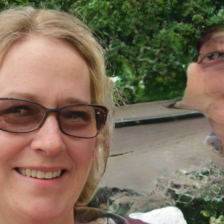

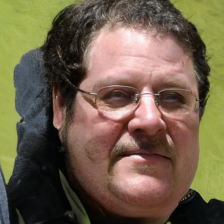

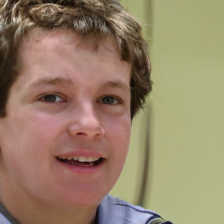

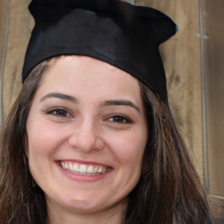

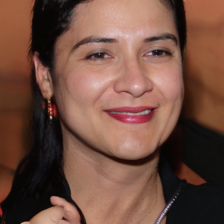

Cosine Similarity between Image Vectors
+---------+-----------+-----------+-----------+-----------+-----------+
|         |   Image 1 |   Image 2 |   Image 3 |   Image 4 |   Image 5 |
+=========+===========+===========+===========+===========+===========+
| Image 1 |    1      |    0.7443 |    0.7892 |    0.8422 |    0.6048 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 2 |    0.7443 |    1      |    0.8167 |    0.7559 |    0.6061 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 3 |    0.7892 |    0.8167 |    1      |    0.7803 |    0.6349 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 4 |    0.8422 |    0.7559 |    0.7803 |    1      |    0.5861 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 5 |    0.6048 |    0.6061 |    0.6349 |    0.5861 |    1      |
+---------+-----------+-----------+-----------+-----------+-----------+

Cosine Similarity betwe

In [15]:
def normalize(X): # функция нормализации вектора
    return (X-X.mean())/X.std()
vec_B = []
lat_vectors = []
lat_vectors.append(zs[0].cpu().numpy())
B = image_vectors[0].reshape(1, -1)
vec_B.append(B[0])
l = torch.tensor(normalize(pca_image.transform(B)), device=device)
lat_vectors.append(l.cpu().numpy()[0])
generated_images = []
for i in range(4):
    q = (G.mapping(l, None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    image = G.synthesis(q * w_stds + G.mapping.w_avg)
    generated_images.append(image)

    preprocessed_images = []
    # Удаление лишнего измерения
    image = image.squeeze(0)
    # Преобразование изображения в формат, подходящий для входа в InceptionV3
    image = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))  # Преобразование тензора в изображение
    image = image.resize((299, 299))  # Размер изображения должен быть 299x299 для InceptionV3
    image = np.array(image)
    image = preprocess_input(image)  # Предобработка изображения для InceptionV3
    preprocessed_images.append(image)
    preprocessed_images = np.array(preprocessed_images)
    # Передача изображений через InceptionV3 и получение векторов
    image_vectors = D.predict(preprocessed_images)
    B = image_vectors[0].reshape(1, -1)
    vec_B.append(B[0])
    l = torch.tensor(normalize(pca_image.transform(B)), device=device)
    lat_vectors.append(l.cpu().numpy()[0])

q = (G.mapping(l, None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
image = G.synthesis(q * w_stds + G.mapping.w_avg)
generated_images.append(image)
for i, image in enumerate(generated_images):
    display(TF.to_pil_image(tf(image)[0]))

# Вывод косинусной похожести векторов изображений
image_similarity = cosine_similarity(vec_B)
latent_similarity = cosine_similarity(lat_vectors)
# Вывод таблицы косинусной похожести векторов изображений
display_similarity_table(image_similarity, "Cosine Similarity between Image Vectors")

# Вывод таблицы косинусной похожести латентных векторов
display_similarity_table(latent_similarity, "Cosine Similarity between Latent Vectors")

### Эксперимент 3

1/1 [==============================] - 2s 2s/step


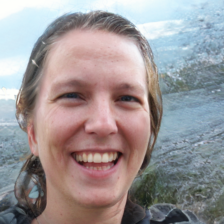

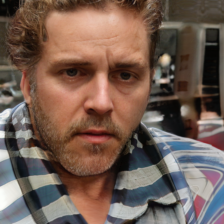

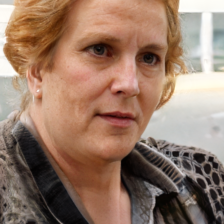

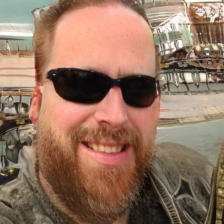

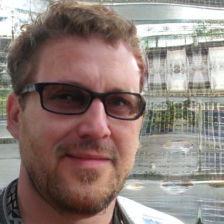

1/1 [==============================] - 2s 2s/step
Image 1, Image 2 - исходыне изображения,  Image 3, Image 4, Image 5 - изображения, полученные комбинацией латентных векторов перового и второго изображений
Cosine Similarity between Image Vectors
+---------+-----------+-----------+-----------+-----------+-----------+
|         |   Image 1 |   Image 2 |   Image 3 |   Image 4 |   Image 5 |
+=========+===========+===========+===========+===========+===========+
| Image 1 |    1      |    0.7187 |    0.7832 |    0.6803 |    0.7366 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 2 |    0.7187 |    1      |    0.8256 |    0.7622 |    0.7546 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 3 |    0.7832 |    0.8256 |    1      |    0.73   |    0.7636 |
+---------+-----------+-----------+-----------+-----------+-----------+
| Image 4 |    0.6803 |    0.7622 |    0.73   |    1      |    0.7823 |
+---------+-----------+-----------

In [16]:
lat_vectors = torch.randn([2, G.mapping.z_dim], device=device)
l = [lat_vectors[0].cpu().numpy(), lat_vectors[1].cpu().numpy()]

# Генерируем изображения для этих латентных векторов
generated_images = []
for latent_vector in lat_vectors:

    q = (G.mapping(latent_vector.unsqueeze(0), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    image = G.synthesis(q * w_stds + G.mapping.w_avg)
    generated_images.append(image)



# D = InceptionV3(weights='imagenet', include_top=False, pooling='avg')


preprocessed_images = []
for image in generated_images:
    # Удаление лишнего измерения
    image = image.squeeze(0)
    # Преобразование изображения в формат, подходящий для входа в InceptionV3
    image = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))  # Преобразование тензора в изображение
    image = image.resize((299, 299))  # Размер изображения должен быть 299x299 для InceptionV3
    image = np.array(image)
    image = preprocess_input(image)  # Предобработка изображения для InceptionV3
    preprocessed_images.append(image)


 # Преобразование списка предобработанных изображений в массив numpy
preprocessed_images = np.array(preprocessed_images)

# Передача изображений через InceptionV3 и получение векторов
image_vectors = D.predict(preprocessed_images)

methods = ["half", "alternating", "random"]

for method in methods:
    if method == 'half':

        latent_vector_3 = torch.cat((lat_vectors[0][:lat_vectors[0].shape[0] // 2],
                                         lat_vectors[1][lat_vectors[1].shape[0] // 2:]), dim=0)

    elif method == "alternating":
        latent_vector_3 = torch.empty_like(lat_vectors[0])
        for i in range(lat_vectors[1].shape[0]):
            latent_vector_3[i] = lat_vectors[0][i] if i % 2 == 0 else lat_vectors[1][i]


    elif method == "random":
        random_indices = torch.randint(0, 2, size=(lat_vectors[0].shape[0], ), device=device)
        latent_vector_3 = torch.empty_like(lat_vectors[0])
        for i in range(lat_vectors[0].shape[0]):
            latent_vector_3[i] = lat_vectors[0][i] if random_indices[i] == 0 else lat_vectors[1][i]


    l.append(latent_vector_3.cpu().numpy())
    q = (G.mapping(latent_vector_3.unsqueeze(0), None, truncation_psi=0.7) - G.mapping.w_avg) / w_stds
    image = G.synthesis(q * w_stds + G.mapping.w_avg)
    generated_images.append(image)




for i, image in enumerate(generated_images):
    display(TF.to_pil_image(tf(image)[0]))



preprocessed_images = []
for image in generated_images:
    # Удаление лишнего измерения
    image = image.squeeze(0)
    # Преобразование изображения в формат, подходящий для входа в InceptionV3
    image = Image.fromarray((image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))  # Преобразование тензора в изображение
    image = image.resize((299, 299))  # Размер изображения должен быть 299x299 для InceptionV3
    image = np.array(image)
    image = preprocess_input(image)  # Предобработка изображения для InceptionV3
    preprocessed_images.append(image)


 # Преобразование списка предобработанных изображений в массив numpy
preprocessed_images = np.array(preprocessed_images)

# Передача изображений через InceptionV3 и получение векторов

image_vectors = D.predict(preprocessed_images)




latent_similarity = cosine_similarity(l)
image_similarity = cosine_similarity(image_vectors)
# Вывод таблицы косинусной похожести векторов изображений
print('Image 1, Image 2 - исходыне изображения,  Image 3, Image 4, Image 5 - изображения, полученные комбинацией латентных векторов перового и второго изображений')
display_similarity_table(image_similarity, "Cosine Similarity between Image Vectors")

# Вывод таблицы косинусной похожести латентных векторов
print('Image 1, Image 2 - исходыне латентные вектора,  Image 3, Image 4, Image 5 - латентные вектора, полученные комбинацией исходных латентных векторов')
display_similarity_table(latent_similarity, "Cosine Similarity between Latent Vectors")
